# Optimal Keyboard Layout

## Introduction

The QWERTY keyboard was designed for type writers: common two-letter combinations were intentionally spread out so that, if a typist hit both keys one after another, the levers attached to the keys would not get stuck together. [(Source)](http://www.mit.edu/~jcb/Dvorak/)

These days, there are [many](https://en.wikipedia.org/wiki/AZERTY) [alternative](https://en.wikipedia.org/wiki/Dvorak_keyboard_layout) [keyboard](https://en.wikipedia.org/wiki/Colemak) [layouts](https://en.wikipedia.org/wiki/Neo_(keyboard_layout)). Each of these keyboard are designed with different criteria in mind: the Dvorak keyboard, for example, took finger strength, and key jumps (hurdling) for common two-letter combinations into account.

I wanted to create a keyboard that was /optimal/ according to a criteria I defined, with my own weights for what was important. Below is how I attempted to do so.

Let $f_{i,j}$ represent the number of times $i$ and $j$ are adjacent in a string $s$, $k(x)$ be the location of key $x$, and $d_{k(i),k(j)}$ be the distance between the keys where $i$ and $j$ are located on a keyboard. The cost of writing string $s$ could be modelled as:

$$
\sum_{(i, j) \in s \times s}{d_{k(i), k(j)} \cdot f_{i,j}}
$$

The function $k$ maps characters to locations on a keyboard, so it's a keyboard layout. We can find the function $k$, or the keyboard layout, that minimizes this cost:

$$
\min_{k} \sum_{(i, j) \in s \times s}{d_{k(i), k(j)} \cdot f_{i,j}}
$$

This is really the [quadratic assignment problem](https://en.wikipedia.org/wiki/Quadratic_assignment_problem), which is nice for us, because academics have already spent some time coming up with a few solutions.

Assuming we can solve this optimization problem, we need:
 1. a function $d_{k(i), k(j)}$ which models the "distance" between locations on a keyboard
 2. a function $f_{i,j}$ which gives us the number of adjacent occurrences, or flows between, characters $i$ and $j$ 

## Modelling keyboard location distance $d$

When considering the distance between two locations on a keyboard, I want to take into account
  1. horizontal distance between keys. e.g. on QWERTY the horizontal distance between "a" and "f" would be 3
  2. row jumps e.g. on QWERTY there is 1 row jump from "a" to "q"; 2 row jumps between "a" and "6"
  3. finger strength: I want to use my index and middle fingers more than my ring and pinky fingers
  4. alternating hands: I want to alternate hands to give each hand roughly equal utilization
  
The distance would then be a weighted sum of the four metrics

Instead of alternating hands, some people may prefer "runs" of characters e.g. on QWERTY "hjkl" would be a run of length 4. This criteria is subjective and you can change the distance function to suit your needs.

We can label the locations of keys as follows (shown on the QWERTY layout):


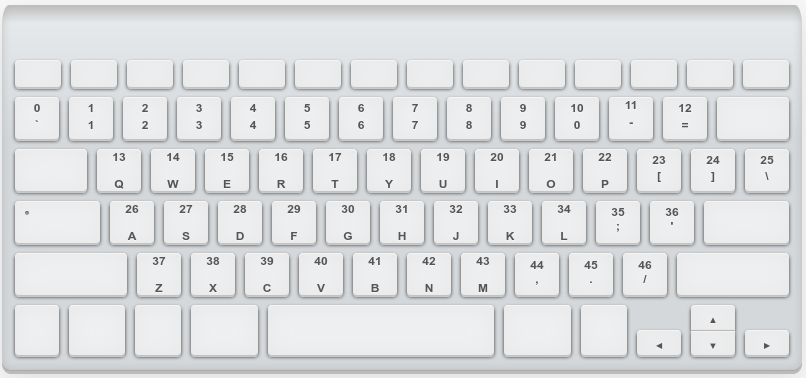

A few mappings to help us later:

In [10]:
lower_case_chars = "`1234567890-=qwertyuiop[]\\asdfghjkl;'zxcvbnm,./"
char_to_location = {c : i 
                    for i, c in enumerate(list(lower_case_chars))}
char_to_location.update({c : i 
                         for i, c in enumerate(list("~!@#$%^&*()_+"))})

char_to_location['{'] = 23
char_to_location['}'] = 24
char_to_location['|'] = 25
char_to_location[':'] = 35
char_to_location['"'] = 36
char_to_location['<'] = 44
char_to_location['>'] = 45
char_to_location['?'] = 46

location_to_char = {}
for k, v in char_to_location.items():
    if v in location_to_char: continue
    location_to_char[v] = k

In [11]:
num_row = range(13)
top_row = range(13, 26)
home_row = range(26, 37)
bottom_row = range(37, 47)

Location to hand mappings:

In [12]:
from enum import Enum

class Hand(Enum):
    LEFT = 1
    RIGHT = 2

location_to_hand = {k : Hand.LEFT if k <= 5 else Hand.RIGHT for k in num_row}
location_to_hand.update({k : Hand.LEFT if k <= 17 else Hand.RIGHT for k in top_row})
location_to_hand.update({k : Hand.LEFT if k <= 30 else Hand.RIGHT for k in home_row})
location_to_hand.update({k : Hand.LEFT if k <= 41 else Hand.RIGHT for k in bottom_row})

Location to finger mappings, and cost of pressing a key with each finger:

In [13]:
class Finger(Enum):
    PINKY = 1
    RING = 2
    OTHER = 3

def compute_finger_costs(finger_strength_weight):
    return {Finger.PINKY : finger_strength_weight/2,
            Finger.RING  : finger_strength_weight/2 * 0.7,
            Finger.OTHER : 0}

pinky_keys = (0, 1, 13, 26, 37, 10, 11, 12, 22, 23, 24, 25, 35, 36, 46)
ring_keys = (2, 14, 27, 38, 9, 21, 34)
location_to_finger = {k : Finger.PINKY for k in pinky_keys}
location_to_finger.update({k : Finger.RING for k in ring_keys})
location_to_finger.update({k : Finger.OTHER 
                           for k in range(47) 
                           if k not in pinky_keys and k not in ring_keys})

Location to row mappings, and the cost of a row jump:

In [14]:
class Row(Enum):
    NUM = 0
    TOP = 1
    HOME = 2
    BOTTOM = 3

location_to_row = {k : Row.NUM for k in num_row}
location_to_row.update({k : Row.TOP for k in top_row})
location_to_row.update({k : Row.HOME for k in home_row})
location_to_row.update({k : Row.BOTTOM for k in bottom_row})

def compute_row_cost(vertical_dist_weight):
    row_move_cost = vertical_dist_weight / 3
    return {Row.NUM : 2 * row_move_cost, 
            Row.TOP: row_move_cost, 
            Row.HOME: 0, 
            Row.BOTTOM: row_move_cost}

The weights assigned to each metric:

In [15]:
w_finger_strength = 30
w_alt_hands = 20
w_vertical_dist = 40
w_horizontal_dist = 10

Computing the distance function for all pairwise locations on the keyboard:

In [17]:
row_cost = compute_row_cost(w_vertical_dist)
finger_costs = compute_finger_costs(w_finger_strength)
horizontal_key_move_cost = w_horizontal_dist / 13

def get_horizontal_offset(i):
    for row in [num_row, top_row, home_row, bottom_row]:
        if i in row: return row.index(i)

def location_pair_cost(i, j):
    if i == j: return 0
    if i > j: return location_pair_cost(j, i)
    finger_cost = finger_costs[location_to_finger[i]] + finger_costs[location_to_finger[j]]
    hand_cost = w_alt_hands * (1 if location_to_hand[i] != location_to_hand[j] else 0)
    vertical_cost = row_cost[location_to_row[i]] + row_cost[location_to_row[j]]
    
    horizontal_i, horizontal_j = get_horizontal_offset(i), get_horizontal_offset(j)
    horizontal_cost = horizontal_key_move_cost * abs(horizontal_i - horizontal_j)
    
    return finger_cost + hand_cost + vertical_cost + horizontal_cost
    
distances = [[location_pair_cost(i, j) for i in range(47)] for j in range(47)]

## Counting adjacent character occurrences

Computing the adjacent character counts is relatively easy, but the art is in finding the corpus to compute occurrences for. I decided to use "Alice's Adventures in Wonderland" as my corpus. A better corpus maybe the emails in my "Sent" folder, or the source code in my git repositories.

But for now, let's continue down this rabbit hole.

In [23]:
from collections import Counter

corpus = None

with open('alice-in-wonderland.txt', 'r') as f:
    corpus = f.read()

assert(corpus is not None)

corpus = list(
    filter(lambda c : c in char_to_location, 
        map(lambda c : c.lower(), corpus)))

char_frequencies = Counter("".join(sorted((corpus[i], corpus[i+1])))
                            for i in range(len(corpus) - 1))

In [24]:
key_flows = [[0 for _ in range(47)] for _ in range(47)]
for k, v in char_frequencies.items():
    i = char_to_location[k[0]]
    j = char_to_location[k[1]]
    key_flows[i][j] = v

Great! Now we have the two matrices we needed. And since this is Python, we just need to do "pip install qap_solver" and:

In [19]:
import qap_solver
qap_solver.solve(key_flows, distances)

ModuleNotFoundError: No module named 'qap_solver'

Oh no.

## Using FANT to approximate a solution

There are several algorithms, problem instances and solutions for the QAP problem [here](https://coral.ise.lehigh.edu/data-sets/qaplib/qaplib-software-for-qap/). The deterministic programs I found (based on branch-and-bound methods) were really slow for my 47 by 47 matrices, and unfortunately this problem is $NP$-hard, so there (probably) isn't a polynomial time algorithm to solve it.

Instead, I used a heuristic based approximation algorithm: the Fast ANT (FANT) algorithm described [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.421.6215&rep=rep1&type=pdf), [here](https://nathanbrixius.wordpress.com/2018/11/26/optimizing-19th-century-typewriters/), and [here](http://mistic.heig-vd.ch/taillard/).

In [25]:
import random

def uniform(lo, hi):
    return lo + int((hi - lo + 1.0) * random.uniform(0,1))

class FANT:
    def __init__(self, n, a, b):
        assert(n > 0 and n == len(a) and n == len(a[0]) \
               and n == len(b) and n == len(b[0]))
        
        self.n = n
        self.a = a
        self.b = b
                
        self.best_p = list(range(n))
        self.p = list(range(n))
        self.best_cost = None
        self.trace = None
        
        self.increment = 1
        self.R = 5
        self.iterations = 1000
    
    def init_trace(self):
        self.trace = [[self.increment for _ in range(self.n)] for _ in range(self.n)]
    
    def update_trace(self):
        i = 0
        while i < len(self.p) and self.p[i] == self.best_p[i]: i += 1
        if i == len(self.p):
            self.increment += 1
            return self.init_trace()
        else:
            for i in range(self.n):
                self.trace[i][self.p[i]] += self.increment
                self.trace[i][self.best_p[i]] += self.R

    def generate_solution_trace(self):
        next_i = self.p[:]; random.shuffle(next_i)
        next_j = self.p[:]; random.shuffle(next_j)
        
        sum_trace = [
            sum([self.trace[i][j] for j in range(self.n)]) 
            for i in range(self.n)
        ]
        
        for i in range(self.n):
            target = uniform(0, sum_trace[next_i[i]])
            j = i
            sum_ = self.trace[next_i[i]][next_j[j]]
            while sum_ < target:
                j += 1
                sum_ += self.trace[next_i[i]][next_j[j]]
            self.p[next_i[i]] = next_j[j]
            for k in range(i, self.n):
                sum_trace[next_i[k]] -= self.trace[next_i[k]][next_j[j]]
            next_j[j], next_j[i] = next_j[i], next_j[j]

    def compute_delta(self, r, s):
        a = self.a
        b = self.b
        p = self.p
        d = (a[r][r] - a[s][s]) * (b[p[s]][p[s]] - b[p[r]][p[r]]) + \
        (a[r][s] - a[s][r]) * (b[p[s]][p[r]] - b[p[r]][p[s]])
        for k in range(self.n):
            if k in (r,s): continue
            d += (a[k][r]-a[k][s])*(b[p[k]][p[s]]-b[p[k]][p[r]]) + \
            (a[r][k]-a[s][k])*(b[p[s]][p[k]]-b[p[r]][p[k]])
        return d
    
    def compute_cost(self):
        p = self.p
        return sum(self.a[i][j] * self.b[p[i]][p[j]] 
                   for i in range(self.n) 
                   for j in range(self.n))
    
    
    def local_search(self, cost):
        moves = [0 for _ in range(self.n*(self.n-1)//2)]
        num_moves = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                moves[num_moves] = self.n*i + j
                num_moves += 1

        for _ in range(2):
            improved = False
            for i in range(num_moves - 1):
                j = uniform(i+1, num_moves-1)
                moves[i], moves[j] = moves[j], moves[i]
            for i in range(num_moves):
                r = moves[i]//self.n
                s = moves[i] % self.n
                delta = self.compute_delta(r, s)
                if delta < 0:
                    cost += delta
                    self.p[r], self.p[s] = self.p[s], self.p[r]
                    improved = True
            if not improved: break
        return cost
    
    def solve(self):
        self.init_trace()
        for iter_no in range(self.iterations):
            p = self.generate_solution_trace()
            cost = self.compute_cost()
            cost = self.local_search(cost)
            if self.best_cost is None or cost < self.best_cost:
                self.best_cost = cost
                for k in range(self.n): self.best_p[k] = self.p[k]
                self.increment = 1
                self.init_trace()
            else:
                self.update_trace()
        print(self.best_cost)
        return self.best_p

In [26]:
f = FANT(47, key_flows, distances)

The cost of the QWERTY keyboard:

In [27]:
p = list(range(47))
sum(key_flows[i][j] * distances[p[i]][p[j]] 
                   for i in range(47) 
                   for j in range(47))

4159267.948717947

In [28]:
p = f.solve()

2510988.1282051248


And finally, the *optimal* keyboard layout:

In [ ]:
keys = [location_to_char[i] for i in p]
print(" ".join(keys[:13]) + "\n " + \
      " ".join(keys[13:26]) + "\n  " + \
      " ".join(keys[26:37]) + "\n   " + \
      " ".join(keys[37:]))

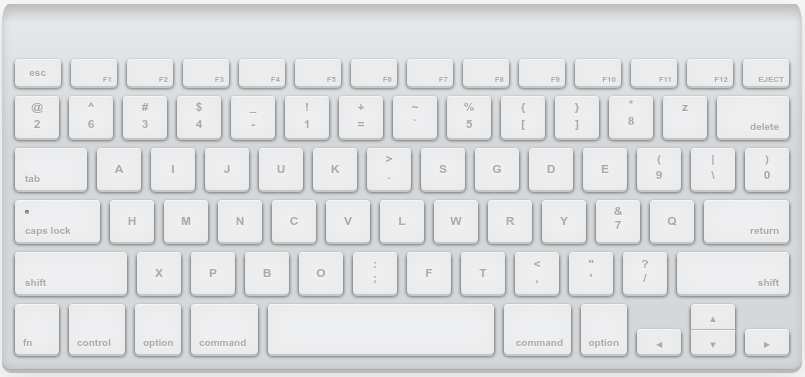